In [11]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

In [12]:
airport_metadata = pd.read_csv("../data/airport_metadata.csv")
airport_coordinates = pd.read_csv("../data/airport_coordinates.csv")
airport_data = airport_metadata.merge(airport_coordinates, left_on="IATA airport code", right_on="iata_code")

# Schedules

A snapshot of flight schedules from each location entry in our airport metadata. It gives estimated times (duration, arr_time, dep_time) as well as the real measured time (arr_/dep_/duration_actual) for planes that have already landed.

In [13]:
schedules = pd.read_csv("../data/airport_schedules.csv")

# Only consider schedules that are within our european airport network
schedules = schedules[schedules["arr_iata"].isin(airport_data["iata_code"])]
display(schedules)

,airline_iata,airline_icao,flight_iata,flight_icao,flight_number,dep_iata,dep_icao,dep_terminal,dep_gate,dep_time,...,arr_delayed,aircraft_icao,arr_time_ts,dep_time_ts,arr_estimated_ts,dep_estimated_ts,dep_actual_ts,arr_actual,arr_actual_utc,arr_actual_ts
0,W9,WUK,W94466,WUK4466,4466,TIA,LATI,NaN,NaN,2024-01-04 12:25,...,NaN,NaN,1704380100,1704367500,1.704379e+09,1.704367e+09,1.704367e+09,NaN,NaN,NaN
1,W4,WMT,W46633,WMT6633,6633,TIA,LATI,NaN,NaN,2024-01-04 12:30,...,9.0,NaN,1704378600,1704367800,1.704379e+09,1.704367e+09,1.704367e+09,NaN,NaN,NaN
2,ZB,ABN,ZB2011,ABN2011,2011,TIA,LATI,NaN,NaN,2024-01-04 12:40,...,NaN,A319,1704375600,1704368400,NaN,NaN,NaN,NaN,NaN,NaN
3,2B,AWT,2B233,AWT233,233,TIA,LATI,NaN,NaN,2024-01-04 12:00,...,NaN,B734,1704372600,1704366000,NaN,1.704369e+09,1.704369e+09,NaN,NaN,NaN
4,W4,WMT,W46673,WMT6673,6673,TIA,LATI,NaN,NaN,2024-01-04 12:55,...,NaN,NaN,1704375000,1704369300,NaN,1.704369e+09,1.704369e+09,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22960,BA,BAW,BA4064,BAW4064,4064,SOU,EGHI,NaN,NaN,2024-01-08 19:55,...,NaN,NaN,1704748800,1704743700,NaN,NaN,NaN,NaN,NaN,NaN
22962,LM,LOG,LM490,LOG490,490,SOU,EGHI,NaN,NaN,2024-01-08 19:55,...,NaN,E145,1704748800,1704743700,NaN,NaN,NaN,NaN,NaN,NaN
22963,EI,EIN,EI3309,EIN3309,3309,SOU,EGHI,NaN,NaN,2024-01-08 20:10,...,NaN,NaN,1704750300,1704744600,NaN,NaN,NaN,NaN,NaN,NaN
22964,EA,EAI,EA3309,EAI3309,3309,SOU,EGHI,NaN,NaN,2024-01-08 20:10,...,NaN,NaN,1704750300,1704744600,NaN,NaN,NaN,NaN,NaN,NaN


# First approach. 
Only considering schedules that have true duration data (already landed and have entries in "_actual" columns).

In [14]:
schedules["dep_actual_utc"] = pd.to_datetime(schedules["dep_actual_utc"])
schedules["arr_actual_utc"] = pd.to_datetime(schedules["arr_actual_utc"])

schedules = schedules[["dep_iata", "arr_iata", "dep_actual_utc", "arr_actual_utc", "duration"]]
schedules.dropna(inplace=True)
schedules.drop_duplicates(inplace=True)
schedules.reset_index(drop=True, inplace=True)
schedules["duration_actual"] = schedules["arr_actual_utc"] - schedules["dep_actual_utc"]
schedules["duration_actual"] = schedules["duration_actual"].dt.total_seconds().div(60).astype(int)

# Remove outliers (20 minute difference)
schedules = schedules[(abs(schedules["duration"] - schedules["duration_actual"]) < 20)]
display(schedules)

,dep_iata,arr_iata,dep_actual_utc,arr_actual_utc,duration,duration_actual
0,GRZ,MUC,2024-01-04 12:27:00,2024-01-04 13:19:00,50,52
1,VIE,SKG,2024-01-04 11:38:00,2024-01-04 13:11:00,105,93
2,VIE,KIV,2024-01-04 11:39:00,2024-01-04 13:16:00,95,97
3,VIE,TIA,2024-01-04 11:46:00,2024-01-04 13:11:00,90,85
4,VIE,KRK,2024-01-04 11:46:00,2024-01-04 12:49:00,60,63
...,...,...,...,...,...,...
354,LHR,CGN,2024-01-08 10:01:00,2024-01-08 11:18:00,80,77
356,LHR,MAN,2024-01-08 10:12:00,2024-01-08 11:08:00,65,56
357,LHR,DUB,2024-01-08 10:27:00,2024-01-08 11:43:00,90,76
358,LTN,AMS,2024-01-08 09:58:00,2024-01-08 11:09:00,70,71


,dep_iata,arr_iata,dep_actual_utc,arr_actual_utc,duration,duration_actual,distance
0,GRZ,MUC,2024-01-04 12:27:00,2024-01-04 13:19:00,50,52,312674.0
1,VIE,SKG,2024-01-04 11:38:00,2024-01-04 13:11:00,105,93,986566.0
2,VIE,KIV,2024-01-04 11:39:00,2024-01-04 13:16:00,95,97,937463.0
3,VIE,TIA,2024-01-04 11:46:00,2024-01-04 13:11:00,90,85,785382.0
4,VIE,KRK,2024-01-04 11:46:00,2024-01-04 12:49:00,60,63,320337.0
...,...,...,...,...,...,...,...
354,LHR,CGN,2024-01-08 10:01:00,2024-01-08 11:18:00,80,77,532225.0
356,LHR,MAN,2024-01-08 10:12:00,2024-01-08 11:08:00,65,56,242949.0
357,LHR,DUB,2024-01-08 10:27:00,2024-01-08 11:43:00,90,76,449547.0
358,LTN,AMS,2024-01-08 09:58:00,2024-01-08 11:09:00,70,71,353625.0


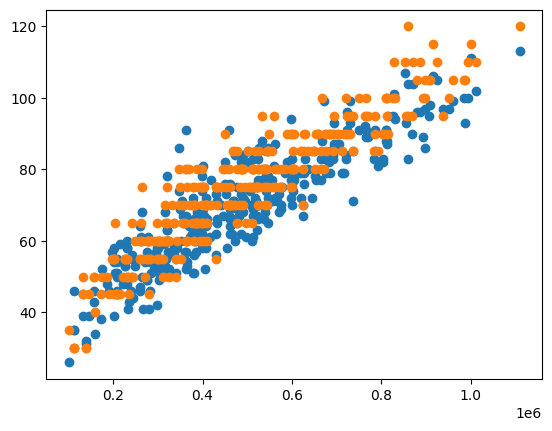

In [15]:
airport_network = nx.read_gml("../data/airport_network.gml")

for i, (dep, arr) in schedules[["dep_iata", "arr_iata"]].iterrows():
    if airport_network.has_edge(dep, arr):
        schedules.at[i, "distance"] = airport_network.edges[dep, arr]["distance"]

display(schedules)
plt.scatter(schedules["distance"], schedules["duration_actual"])
plt.scatter(schedules["distance"], schedules["duration"])

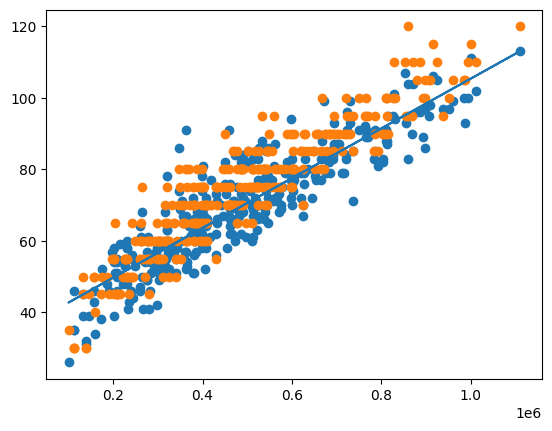

In [16]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
X = schedules["distance"].values.reshape(-1, 1)
y = schedules["duration_actual"].values.reshape(-1, 1)
model.fit(X, y)
plt.scatter(schedules["distance"], schedules["duration_actual"],)
plt.scatter(schedules["distance"], schedules["duration"])
plt.plot(X, model.predict(X))

In [17]:
import scripts.FlightEstimator as estimator

print("Flight from Vienna -> Hannover = 90 minutes (source: Google Flights)")

print(f"Prediction: {model.predict([[685332]])} minutes".replace('[', '').replace(']', ''))

print(f"Calculation: {(estimator.calculate_duration(685332) / 60) - estimator.boarding_time - estimator.alight_time} minutes")

Flight from Vienna -> Hannover = 90 minutes (source: Google Flights)
Prediction: 83.46119118 minutes
Calculation: 74.76666666666667 minutes


# Second Approach
Trying again with all estimated times, which has 4605 datapoints instead of 169. Estimated arrival times are often slightly pessimistic.

In [18]:
schedules = pd.read_csv("../data/airport_schedules.csv")

schedules = schedules[schedules["arr_iata"].isin(airport_data["iata_code"])]

schedules = schedules[["dep_iata", "arr_iata", "duration"]]
schedules.dropna(inplace=True)
schedules.drop_duplicates(inplace=True)
schedules.reset_index(drop=True, inplace=True)

# Remove outliers
schedules = schedules[~(schedules["duration"] > 1000)]

,dep_iata,arr_iata,duration,distance
0,TIA,LTN,210,1912943.0
1,TIA,BVA,180,1631963.0
2,TIA,VRN,120,837947.0
3,TIA,BGY,110,933984.0
4,TIA,CIY,95,659725.0
...,...,...,...,...
5510,NCL,KRK,160,1545964.0
5511,NCL,BCN,150,1552658.0
5512,NCL,PFO,285,3456188.0
5513,NCL,KRK,150,1545964.0


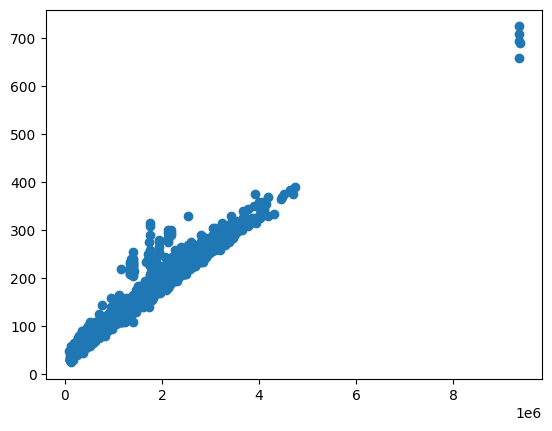

In [19]:
airport_network = nx.read_gml("../data/airport_network.gml")

for i, (dep, arr) in schedules[["dep_iata", "arr_iata"]].iterrows():
    if airport_network.has_edge(dep, arr):
        schedules.at[i, "distance"] = airport_network.edges[dep, arr]["distance"]
display(schedules)

plt.scatter(schedules["distance"], schedules["duration"])

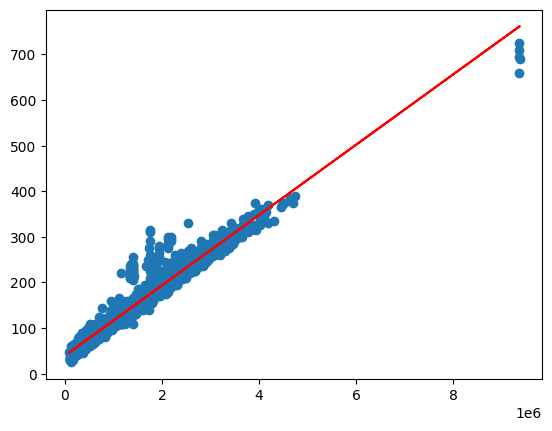

In [20]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
X = schedules["distance"].values.reshape(-1, 1)
y = schedules["duration"].values.reshape(-1, 1)
model.fit(X, y)
plt.scatter(schedules["distance"], schedules["duration"])
plt.plot(X, model.predict(X), color="red")

In [21]:
import scripts.FlightEstimator as estimator

print("Flight from London -> Rome = 140 minute average (source: cleartrip.com)")
print(f"Prediction: {model.predict([[1438516]])}".replace('[', '').replace(']', ''))
print(f"Calculation: {(estimator.calculate_duration(1438516) / 60) - estimator.boarding_time - estimator.alight_time}")

Flight from London -> Rome = 140 minute average (source: cleartrip.com)
Prediction: 150.27027632
Calculation: 156.93333333333334


# Storing the data
Writing duration into the flight network **using the second approach**:

In [26]:
airport_network = nx.read_gml("../data/airport_network.gml")

for place, dest, distance in airport_network.edges(data="distance"):
    duration = round((model.predict([[distance]])[0][0] + estimator.boarding_time + estimator.alight_time))
    airport_network.add_edge(place, dest, distance=distance, duration=duration)

nx.write_gml(airport_network, "../data/airport_network.gml")

# Analysing aiport & flight data

## Airport data
9 cities share several airports. Take only nearest Airport? Include them all and connect them to the cities by car/train? Some are very far away (eg. HHN airport, 1.5 hours away from Frankfurt by car).


In [62]:
# Checking for cities with several airports in our data:
airports_duplicated = airport_metadata.duplicated('city', keep=False)
display(airport_metadata[airports_duplicated])

,Airport,Country,IATA airport code,ICAO airport code,city
56,Paris Beauvais Airport,France,BVA,LFOB,Paris
57,Paris Charles de Gaulle Airport,France,CDG,LFPG,Paris
58,Paris Orly Airport,France,ORY,LFPO,Paris
73,Frankfurt Airport,Germany,FRA,EDDF,Frankfurt
74,Frankfurt-Hahn Airport,Germany,HHN,EDFH,Frankfurt
121,Milan Linate Airport,Italy,LIN,LIML,Milan
122,Milan Malpensa Airport,Italy,MXP,LIMC,Milan
129,Rome Ciampino Airport,Italy,CIA,LIRA,Rome
130,Rome Fiumicino Airport,Italy,FCO,LIRF,Rome
169,Warsaw Airport,Poland,WAW,EPWA,Warsaw


## Route data
Our flight network connects all airports right now. Does not reflect actual flight routes. The 'routes' dataset from [OpenFlights](https://github.com/jpatokal/openflights) has over 60k real flight routes, could be used to define routes between airports in our network.

In [93]:
routes = pd.read_csv("../data/routes.csv")
merged_df = pd.merge(schedules, routes, on=['dep_iata', 'arr_iata'], how='outer', indicator=True)

# result contains routes found in schedules that are missing in the routes dataset.
result = merged_df[merged_df['_merge'] == 'left_only']

print("Example of missing routes:\n", result[["dep_iata","arr_iata"]].head(), "\n")
print(f"{len(result)} routes are missing in routes.csv that where found in the Airlabs schedule data")

Example of missing routes:
    dep_iata arr_iata
0       TIA      LTN
1       TIA      BVA
15      TIA      CIY
16      TIA      CRL
17      TIA      CRL 

665 routes are missing in routes.csv that where found in the Airlabs schedule data


Route data is incomplete/too old and cannot be used to define our airport network routes.